In [505]:
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

import torch
from torch import nn
device = 'cpu'

from plotly.offline import iplot, init_notebook_mode
init_notebook_mode()
import plotly.graph_objs as go

from matplotlib import rcParams

rcParams['figure.figsize'] = 8,8

## Implement Lorenz

In [5]:
# From Matt Levine's GitHub at https://github.com/mattlevine22/contRNN

def Lorenz_63(S, t, sigma=10.0, rho=28.0, beta=8.0/3):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1]-S[0]);
    x_2 = S[0]*(rho-S[2])-S[1];
    x_3 = S[0]*S[1] - beta*S[2];
    dS  = np.array([x_1,x_2,x_3]);
    return dS

def L63_torch(S, t, sigma=10.0, rho=28.0, beta=8.0/3):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1]-S[0])
    x_2 = S[0]*(rho-S[2])-S[1]
    x_3 = S[0]*S[1] - beta*S[2]
    dS  = torch.vstack((x_1,x_2,x_3))
    return dS

In [30]:
dt = 0.01
x_0 = np.array([8, 0, 30])
t_space = np.arange(0, 5, dt)

true_state = odeint(Lorenz_63, x_0, t_space)

trace = go.Scatter3d(
    x = true_state[:,0],
    y = true_state[:,1],
    z = true_state[:,2],
    mode = 'markers',
    name = 'true state',
    marker = {'size' : 2, 'color' : 'blue'}
)

layout = {
    'title': {
        'text' : 'True State of Lorenz Equations'
    }
}

iplot({'data' : [trace], 'layout' : layout})

## Generating Data

In [8]:
from sklearn.gaussian_process.kernels import RBF
from scipy.integrate import odeint

In [181]:
sigma=10.0
rho=28.0
beta=8.0/3

In [9]:
def L63_perturb_y(S, t, sigma=10.0, rho=28.0, beta=8.0/3, eps=0.01):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1] - S[0])
    x_2 = S[0]*(rho*(1 - eps) - S[2]) - S[1]
    x_3 = S[0]*S[1] - beta*S[2]
    dS  = np.array([x_1,x_2,x_3])
    return dS

def L63_gaussian_process(S, t, sigma=10.0, rho=28.0, beta=8.0/3, eps=0.01):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1]-S[0])
    x_2 = S[0]*(rho-S[2])-S[1]
    x_3 = S[0]*S[1] - beta*S[2]
    dS  = np.array([x_1,x_2,x_3])
    return dS

def L63_torch_perturb_y(S, t, sigma=10.0, rho=28.0, beta=8.0/3, eps=0.01):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1] - S[0])
    x_2 = S[0]*(rho*(1 - eps) - S[2]) - S[1]
    x_3 = S[0]*S[1] - beta*S[2]
    dS  = torch.vstack((x_1,x_2,x_3))
    return dS

def L63_torch_gaussian_process(S, t, sigma=10.0, rho=28.0, beta=8.0/3, eps=0.01):
    """ Lorenz-63 dynamical model. """
    x_1 = sigma*(S[1]-S[0])
    x_2 = S[0]*(rho-S[2])-S[1]
    x_3 = S[0]*S[1] - beta*S[2]
    dS  = torch.vstack((x_1,x_2,x_3))
    return dS

In [399]:
def my_gaussian_kernel(x, y, length_scale=10):
    return np.exp( - np.linalg.norm(x-y)**2 / (2*length_scale**2))

def gaussian_process_transform(data, eps = 0.05, ret='data'):
    n = data.shape[1]
    transform = np.eye(n)
    draws = np.random.multivariate_normal(np.zeros(n), np.diag(np.var(data, axis=0)), n)
    
    for i in range(n):
        for j in range(i+1,n):
            gp = eps*my_gaussian_kernel(draws[i,:], draws[j,:], length_scale=10)
            if np.random.rand() < 0.5:
                gp = -gp
            transform[i,j] = gp
            transform[j,i] = gp

    if ret == 'data':
        return data @ transform
    elif ret == 'transform':
        return transform
    else:
        raise ValueError("This function doesn't return the quantity you want")

In [364]:
dt = 0.01
x_0 = np.array([8, 0, 30])
t_space = np.arange(0, 5, dt)
eps = 0.05

true_state = odeint(Lorenz_63, x_0, t_space)
perturbed_state = odeint(L63_perturb_y, x_0, t_space, args=(sigma, rho, beta, eps))
N = true_state.shape[0]

noisy_state = gaussian_process_transform(true_state, eps=eps)


trace = go.Scatter3d(
    x = true_state[:,0],
    y = true_state[:,1],
    z = true_state[:,2],
    mode = 'markers',
    name = 'true state',
    marker = {'size' : 2, 'color' : 'blue'}
)

trace_perturb = go.Scatter3d(
    x = perturbed_state[:,0],
    y = perturbed_state[:,1],
    z = perturbed_state[:,2],
    mode = 'markers',
    name = 'pertubed y',
    marker = {'size' : 2, 'color' : 'green'}
)

trace_noisy = go.Scatter3d(
    x = noisy_state[:,0],
    y = noisy_state[:,1],
    z = noisy_state[:,2],
    mode = 'markers',
    name = 'noisy transform',
    marker = {'size' : 2, 'color' : 'red'}
)

layout = {
    'title': {
        'text' : 'Different Kinds of Agitation'
    }
}

iplot({'data' : [trace, trace_perturb, trace_noisy], 'layout' : layout})

### Check for noisy transform having mean 0

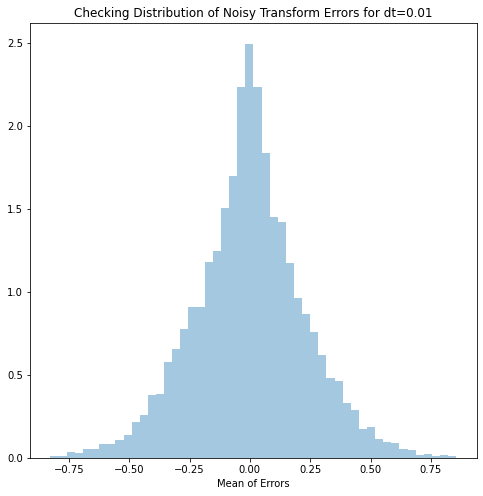

In [511]:
N_sym = 10000
means = np.zeros(N_sym)

for i in range(N_sym):
    means[i] = np.mean(true_state - gaussian_process_transform(true_state))
    
sns.distplot(means, kde=False, norm_hist=True)
plt.title('Checking Distribution of Noisy Transform Errors for dt={}'.format(dt))
plt.xlabel('Mean of Errors')
plt.show()

### Adding Smoothed Random Noise

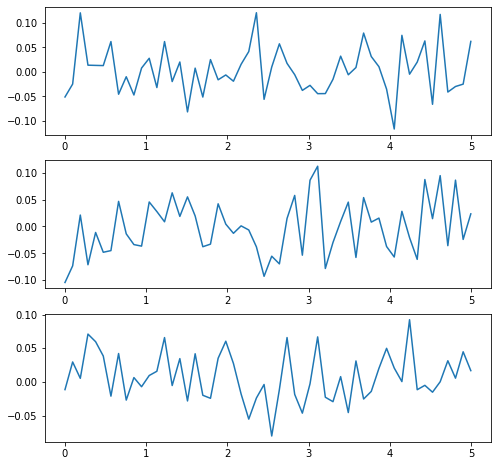

In [318]:
dt_noise = 3*np.pi * dt
t_space_noise = np.arange(0, 5 + 4*dt, dt_noise)
random_fns = []

for d in range(3):
    pts = np.random.normal(0, eps, len(t_space_noise))
    interp = scipy.interpolate.interp1d(t_space_noise, pts, kind='cubic')
    random_fns.append(interp)

ax1 = plt.subplot(311)
ax1.plot(t_space_noise, random_fns[0](t_space_noise))

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(t_space_noise, random_fns[1](t_space_noise))

ax3 = plt.subplot(313, sharex=ax2)
ax3.plot(t_space_noise, random_fns[2](t_space_noise))

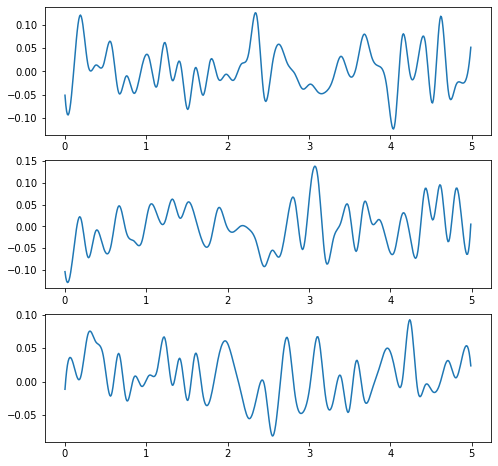

In [319]:
ax1 = plt.subplot(311)
ax1.plot(t_space, random_fns[0](t_space))

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(t_space, random_fns[1](t_space))

ax3 = plt.subplot(313, sharex=ax2)
ax3.plot(t_space, random_fns[2](t_space))

In [396]:
def additive_noise(data, t_space, dt):
    dt_noise = 3*np.pi * dt
    t_space_noise = np.arange(0, 5 + 4*dt, dt_noise)
    random_fns = []

    for d in range(3):
        pts = np.random.normal(0, eps, len(t_space_noise))
        interp = scipy.interpolate.interp1d(t_space_noise, pts, kind='cubic')
        random_fns.append(interp)
    
    noise = np.hstack([random_fns[i](t_space)[:,np.newaxis] for i in range(3)])
    return data + noise

In [512]:
with_noise_added = additive_noise(true_state, t_space, dt)

trace = go.Scatter3d(
    x = true_state[:,0],
    y = true_state[:,1],
    z = true_state[:,2],
    mode = 'markers',
    name = 'true state',
    marker = {'size' : 2, 'color' : 'blue'}
)

trace_add = go.Scatter3d(
    x = with_noise_added[:,0],
    y = with_noise_added[:,1],
    z = with_noise_added[:,2],
    mode = 'markers',
    name = 'added smoothed gaussian error',
    marker = {'size' : 2, 'color' : 'red'}
)

layout = {
    'title': {
        'text' : 'Adding Smoothed Noise'
    }
}

iplot({'data' : [trace, trace_add], 'layout' : layout})

In [421]:
random_ixs = np.random.choice(range(true_state.shape[0]), N_iter, replace=True)
random_starts = true_state[random_ixs,:] + 0.1*np.random.multivariate_normal(np.zeros(3), np.diag(np.var(true_state, axis=0)), N_iter)


trace = go.Scatter3d(
    x = true_state[:,0],
    y = true_state[:,1],
    z = true_state[:,2],
    mode = 'markers',
    name = 'true state',
    marker = {'size' : 2, 'color' : 'blue'}
)

noisy_starts = go.Scatter3d(
    x = random_starts[:,0],
    y = random_starts[:,1],
    z = random_starts[:,2],
    mode = 'markers',
    name = 'actual noise',
    marker = {'size' : 2, 'color' : 'red'}
)

layout = {
    'title': {
        'text' : 'Random Starting Points'
    }
}

iplot({'data' : [trace, noisy_starts], 'layout' : layout})

## Learn the Residuals

### Learning from Perturbed Dynamics with RNNs

In [371]:
N = true_state.shape[0] #number of time draws
d = true_state.shape[1] #number of dimensions

In [437]:
# For the perturbed case, our main method of generating
# more data is by varying the initial state

N_iter = 100

random_ixs = np.random.choice(range(true_state.shape[0]), N_iter, replace=True)
random_starts = true_state[random_ixs,:] + 0.1*np.random.multivariate_normal(np.zeros(3), np.diag(np.var(true_state, axis=0)), N_iter)
err_tensor = np.zeros((true_state.shape[0], true_state.shape[1], N_iter))

for i in range(N_iter):
    x0 = random_starts[:,:,i]
    true_state = odeint(Lorenz_63, x_0, t_space)
    perturb_state = odeint(L63_perturb_y, x_0, t_space, args=(sigma, rho, beta, eps))
    perturb_err = (true_state - perturbed_state)
    err_tensor[:,:,i] = perturb_err
    

err_tensor = torch.tensor(err_tensor, dtype=torch.double)
print(err_tensor)
    
rnn_pertub = nn.RNN(N_iter, 10, num_layers=2, nonlinearity='relu', dropout=0.2)

h0 = torch.randn(2, 3, 10)
learned_err_pertub, _ = rnn_pertub(err_tensor, h0)

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 5.2179e-03,  5.2179e-03,  5.2179e-03,  ...,  5.2179e-03,
           5.2179e-03,  5.2179e-03],
         [ 1.0586e-01,  1.0586e-01,  1.0586e-01,  ...,  1.0586e-01,
           1.0586e-01,  1.0586e-01],
         [ 3.9985e-03,  3.9985e-03,  3.9985e-03,  ...,  3.9985e-03,
           3.9985e-03,  3.9985e-03]],

        [[ 1.9429e-02,  1.9429e-02,  1.9429e-02,  ...,  1.9429e-02,
           1.9429e-02,  1.9429e-02],
         [ 1.9974e-01,  1.9974e-01,  1.9974e-01,  ...,  1.9974e-01,
           1.9974e-01,  1.9974e-01],
         [ 1.4246e-02,  1.4246e-02,  1.4246e-02,  ...,  1.4246e-02,
           1.4246e-02,  1.4246e-02]],

        ...,

        [[ 5.9097e+00,  5.9097e+00,

RuntimeError: expected scalar type Double but found Float

### Learning with Standard MLPs

In [ ]:
class NNLearnPerturb(nn.Module):
    def __init__(self):
        super(NNLearnPerturb, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relustack = nn.Sequential(
            nn.Linear(N, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 500),
            nn.LeakyReLU(),
            nn.Linear(500, N),
        )
        
        def forward(self, x):
            x = self.flatten(x)
            

## Learning with Matrices

In [504]:
def random_feature_map(data, D=50, omega=0.1, beta=0.1):
    Phi = np.zeros((data.shape[0], D))
    w_all = np.random.uniform(-omega, omega, size=(D, data.shape[1]))
    b_all = np.random.uniform(-beta, beta, size=D)
    
    for i in range(D):
        w = w_all[i,:]
        b = b_all[i]
        Phi[:,i] = np.tanh(w @ data.T + b).T
        
    return Phi

print(random_feature_map(true_state))

[[ 0.27692753  0.99031029  0.3865245  ...  0.89777755  0.95438536
  -0.99769107]
 [ 0.29760141  0.98750447  0.42131908 ...  0.89241173  0.95123008
  -0.99694476]
 [ 0.31147676  0.98416262  0.44726767 ...  0.88604348  0.94740711
  -0.99599669]
 ...
 [-0.57869887  0.94210023 -0.5820148  ...  0.22348197  0.3067429
  -0.91205065]
 [-0.61662665  0.94869598 -0.62707759 ...  0.19792908  0.27256171
  -0.91676419]
 [-0.65267803  0.95524845 -0.66888974 ...  0.17461972  0.24022165
  -0.92246432]]


In [509]:
X_train = np.load('../external-repos/contRNN/data/X_train_L63.npy')
X_test = np.load('../external-repos/contRNN/data/X_test_L63.npy')
print(X_train.shape)
print(X_test.shape)

(3, 11001)
(3, 188999)


In [510]:
trace = go.Scatter3d(
    x = X_train.T[:,0],
    y = X_train.T[:,1],
    z = X_train.T[:,2],
    mode = 'markers',
    name = 'true state',
    marker = {'size' : 2, 'color' : 'blue'}
)

layout = {
    'title': {
        'text' : 'Pre-Existing Data'
    }
}

iplot({'data' : [trace], 'layout' : layout})